# Online Payment Fraud Detection Project
### Made by Nikita Gordonov
##### Data: https://www.kaggle.com/datasets/jainilcoder/online-payment-fraud-detection

To identify online payment fraud with machine learning, we need to train a machine learning model for classifying fraudulent and non-fraudulent payments. For this, we need a dataset containing information about online payment fraud, so that we can understand what type of transactions lead to fraud. For this task, I collected a dataset from Kaggle, which contains historical information about fraudulent transactions which can be used to detect fraud in online payments. 

## Importing libraries

In [1]:
# !pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from catboost import Pool, CatBoostRegressor, CatBoostClassifier, cv
from catboost.utils import get_roc_curve

## Reading data

In [3]:
init_df = pd.read_csv(r'~\Downloads\PS_20174392719_1491204439457_log.csv\PS_20174392719_1491204439457_log.csv')
pd.set_option('display.float_format', '{:.2f}'.format)
init_df = init_df.rename(columns={'oldbalanceOrg': 'oldbalanceOrig'})
init_df.drop_duplicates(inplace=True)

In [4]:
# First glance 

init_df.head(10)

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.00,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.00,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.00,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.00,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.00,40348.79,0,0


The dataset consists of 10 variables:

* step: represents a unit of time where 1 step equals 1 hour
* type: type of online transaction
* amount: the amount of the transaction
* nameOrig: customer starting the transaction
* oldbalanceOrg: balance before the transaction
* newbalanceOrig: balance after the transaction
* nameDest: recipient of the transaction
* oldbalanceDest: initial balance of recipient before the transaction
* newbalanceDest: the new balance of recipient after the transaction
* isFraud: fraud transaction 

## EDA

In [5]:
# General information

init_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrig  float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
# Checking for missing values

init_df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrig    0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

* So, there are no missing data

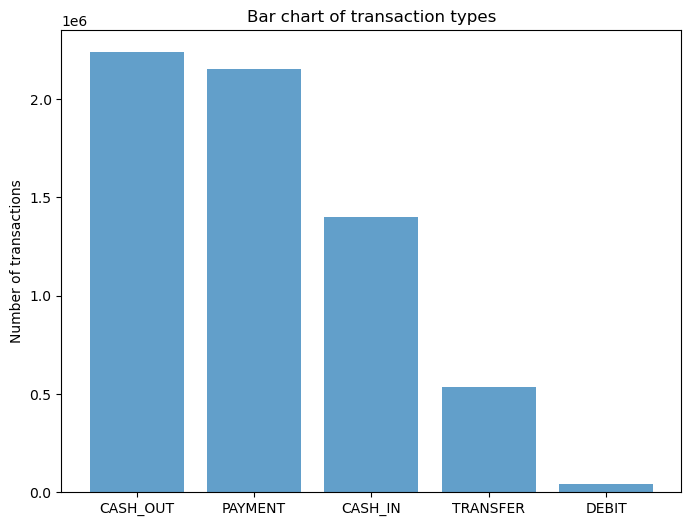

In [7]:
# Distribution of transaction types

plt.figure(figsize=(8, 6))
type_count = init_df['type'].value_counts()
plt.bar(type_count.index, type_count, alpha=0.7)  # Построение гистограммы с 30 бинами
plt.title('Bar chart of transaction types')
plt.ylabel('Number of transactions')
plt.show()

In [8]:
# Descriptive statistics

init_df.describe()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


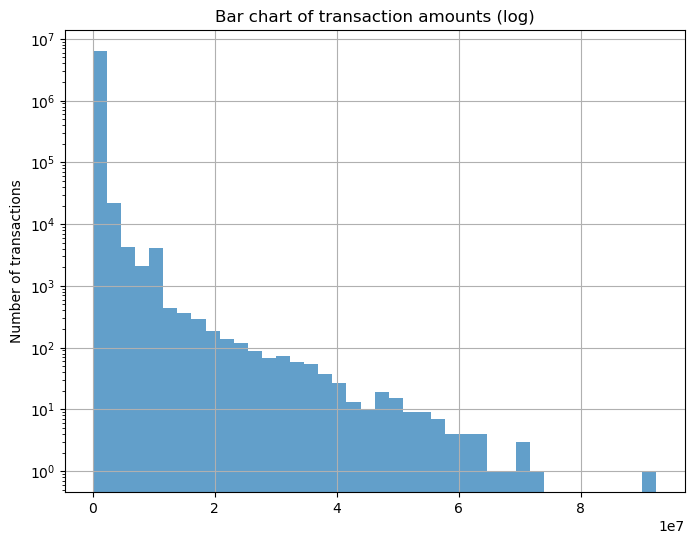

In [9]:
# Distribution of transaction amounts (log)

plt.figure(figsize=(8, 6))
init_df['amount'].hist(bins=40, alpha=0.7)
plt.title('Bar chart of transaction amounts (log)')
plt.ylabel('Number of transactions')
plt.yscale("log")

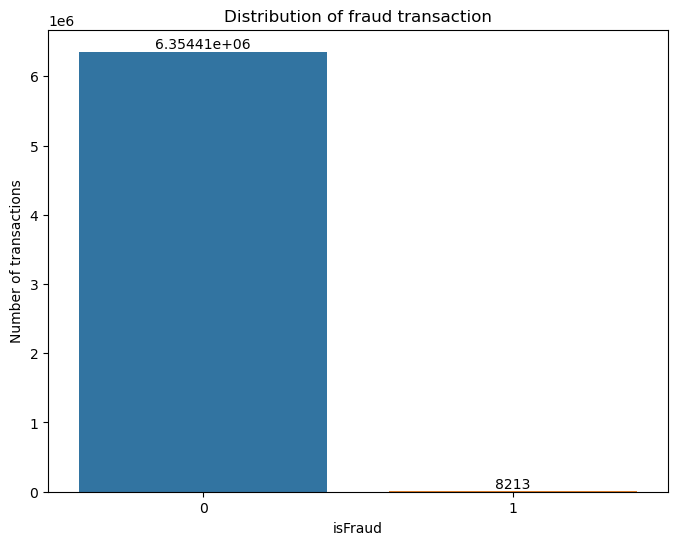

In [10]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='isFraud', data=init_df)
plt.title('Distribution of fraud transaction')
for container in ax.containers:
    ax.bar_label(container)
plt.ylabel('Number of transactions');

* We can observe explicit class imbalance, meaning that the "Fraud" class has significantly fewer instances compared to "Not Fraud" class

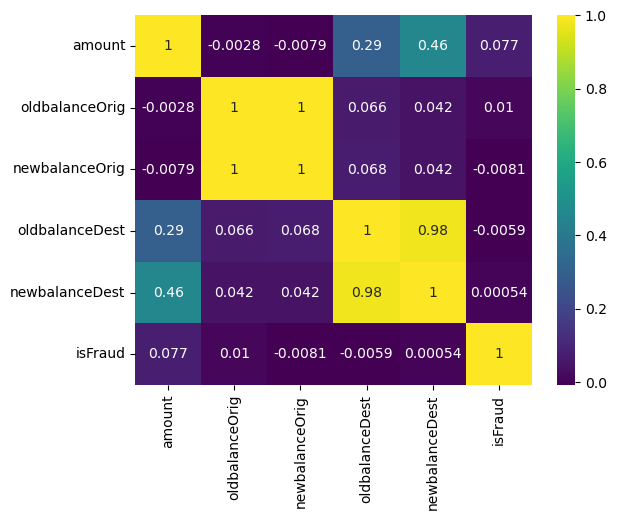

In [11]:
# Correlogram of features

sns.heatmap(init_df[['amount', 'oldbalanceOrig',
       'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
       'isFraud']].corr(), cmap='viridis', annot=True);

* We can observe the problem of multicollinearity in data, so we will need to drop excess highly-correlated features.

In [12]:
# Dropping unnecessary features and text features

df = init_df.drop(['newbalanceOrig', 'newbalanceDest', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)

In [13]:
# One-hot encoding for "type" feature

df = pd.concat([df, 1*pd.get_dummies(df['type'])], axis=1).drop('type', axis=1)

<AxesSubplot:>

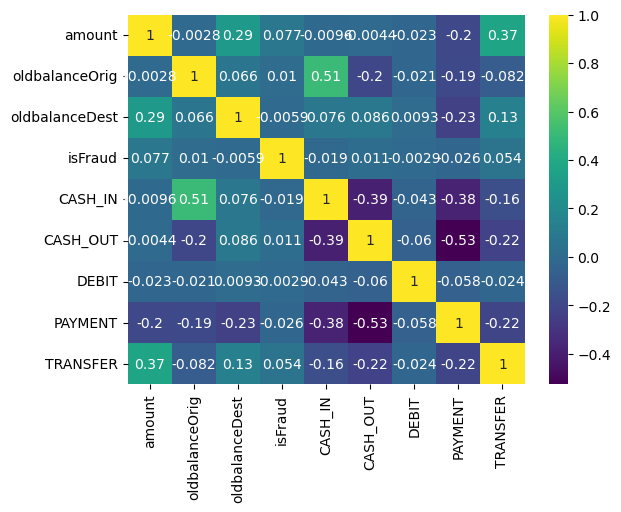

In [14]:
# Final correlogram of features

sns.heatmap(df[['amount', 'oldbalanceOrig',
       'oldbalanceDest', 'isFraud', 'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT',
       'TRANSFER']].corr(), cmap='viridis', annot=True)

* "Payment" feature can be dropped too, because of high correlation with "CASH_OUT" and "CASH_IN"

# Building the model

In [15]:
df = df.drop('PAYMENT', axis=1)

X = df.drop('isFraud', axis = 1)
y = df.isFraud

In [16]:
# Splitgting data into train, validation and test samples

X_not_test, X_test, y_not_test, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42, stratify = y)
X_train, X_eval, y_train, y_eval = train_test_split(X_not_test, y_not_test, test_size = 0.2, stratify = y_not_test, random_state = 42)

### Gradient boosting is likely the best model for such tabular data

**Metrics and business logic** 

The two main metrics for our task are Recall and ROC AUC.

Recall shows how many of the actual fraudulent transactions were detected by the model. This metric is more informative in case of class imbalance than accuracy. Our task is to identify all fraudulent transactions, so we will optimize it.

The ROC-AUC evaluates the model's ability to separate classes from each other. A high ROC-AUC value indicates a good ability of the model to distinguish fraudulent transactions from normal ones. This is the second most important metric.

For a general understanding, we will also monitor the Precision score, i.e. how well the model correctly identifies fraud from all predictions marked as fraud, and the F1 measure, the harmonic mean Recall and Precision.

**Loss**

The type of our problem is Binary Classification, so we will optimize LogLoss.

## Baseline model

In [17]:
# Training catboost

depths = [4,6,8,10]
best_recalls = []
best_models = []

for depth in depths:
    model = CatBoostClassifier(iterations=2000,
                               depth = depth,
                               learning_rate=0.1,
                               loss_function='Logloss',
                               eval_metric = 'Recall', 
                               random_seed = 42)

    model.fit(X_train, y_train,
              eval_set = (X_eval, y_eval),
              verbose=False,
              early_stopping_rounds = 100)
    
    best_recalls.append(model.best_score_['validation']['Recall'])
    best_models.append(model)

In [18]:
best_recalls

[0.790257104194858, 0.786874154262517, 0.8166441136671178, 0.8152909336941814]

In [19]:
best_model_index = best_recalls.index(max(best_recalls))
best_baseline_model = best_models[best_model_index]

In [20]:
print(f'Precision on test: {precision_score(best_baseline_model.predict(X_test), y_test)}\n'
f'Recall on test: {recall_score(best_baseline_model.predict(X_test), y_test)}\n'
f'F1 on test {f1_score(best_baseline_model.predict(X_test), y_test)}\n'
f'ROC AUC on test: {roc_auc_score(best_baseline_model.predict(X_test), y_test)}')

Precision on test: 0.805115712545676
Recall on test: 0.9142461964038727
F1 on test 0.8562176165803109
ROC AUC on test: 0.9569972207970878


In [21]:
# What features make the most impact on the prediction?

best_baseline_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,amount,34.53
1,oldbalanceOrig,34.49
2,CASH_OUT,13.69
3,oldbalanceDest,10.36
4,step,4.06
5,TRANSFER,2.53
6,CASH_IN,0.34
7,DEBIT,0.01


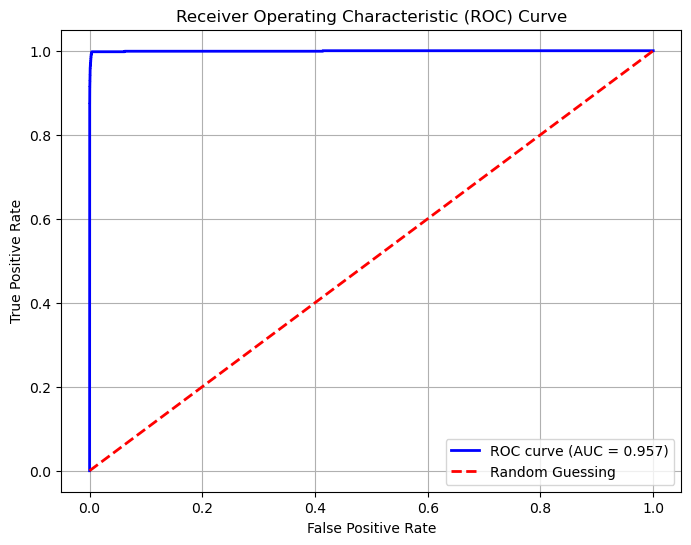

In [22]:
# Plotting the ROC AUC curve of test dataset

curve = get_roc_curve(best_baseline_model, Pool(X_test, y_test))
(fpr, tpr, thresholds) = curve

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc_score(best_baseline_model.predict(X_test), y_test))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

* Almost ideal class separation, but let's try to improve our model with some feature enginneering 

## Feature engineering 

In [23]:
engineered_df = init_df.copy(deep=True)

In [24]:
# Transaction frequency

trans_frequency_Dest = init_df.groupby('nameDest', as_index = False).agg({'amount': 'count'})  \
.rename(columns = {'amount': "trans_frequency_Dest"})

engineered_df = engineered_df.merge(trans_frequency_Dest, how = 'left', on = 'nameDest')

In [25]:
# Average transaction amount

avg_trans_amount_Dest = init_df.groupby('nameDest', as_index = False).agg({'amount': 'mean'})  \
.rename(columns = {'amount': "avg_trans_amount_Dest"})

engineered_df = engineered_df.merge(avg_trans_amount_Dest, how = 'left', on = 'nameDest')

In [26]:
# Variability in transaction amount

variability_trans_amount_Dest = init_df.groupby('nameDest', as_index = False).agg({'amount': 'std'}).fillna(0)  \
.rename(columns = {'amount': "variability_trans_amount_Dest"})

engineered_df = engineered_df.merge(variability_trans_amount_Dest, how = 'left', on = 'nameDest')

In [27]:
# Extraordinary big transaction

big_trans_quantile = round(engineered_df['amount'].quantile(0.9))
engineered_df['big_trans_flag'] = (engineered_df['amount'] > big_trans_quantile) * 1

# New balance equals zero 

engineered_df['zero_new_balance_Dest_flag'] = (engineered_df['newbalanceDest'] == 0) * 1
engineered_df['zero_new_balance_Orig_flag'] = (engineered_df['newbalanceOrig'] == 0) * 1

In [28]:
engineered_df = engineered_df.drop(['newbalanceOrig', 'newbalanceDest', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
engineered_df = pd.concat([engineered_df, 1*pd.get_dummies(engineered_df['type'])], axis=1).drop('type', axis=1)
engineered_df = engineered_df.drop(['PAYMENT'], axis=1)

In [29]:
# Engineered dataset 

engineered_df

,step,amount,oldbalanceOrig,oldbalanceDest,isFraud,trans_frequency_Dest,avg_trans_amount_Dest,variability_trans_amount_Dest,big_trans_flag,zero_new_balance_Dest_flag,zero_new_balance_Orig_flag,CASH_IN,CASH_OUT,DEBIT,TRANSFER
0,1,9839.64,170136.00,0.00,0,1,9839.64,0.00,0,1,0,0,0,0,0
1,1,1864.28,21249.00,0.00,0,1,1864.28,0.00,0,1,0,0,0,0,0
2,1,181.00,181.00,0.00,1,44,225517.83,252655.76,0,1,1,0,0,0,1
3,1,181.00,181.00,21182.00,1,41,439444.21,878990.48,0,1,1,0,1,0,0
4,1,11668.14,41554.00,0.00,0,1,11668.14,0.00,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,1,2,332391.36,10310.71,0,0,1,0,1,0,0
6362616,743,6311409.28,6311409.28,0.00,1,1,6311409.28,0.00,1,1,1,0,0,0,1
6362617,743,6311409.28,6311409.28,68488.84,1,3,2212470.97,3551042.68,1,0,1,0,1,0,0
6362618,743,850002.52,850002.52,0.00,1,1,850002.52,0.00,1,1,1,0,0,0,1


In [30]:
X = engineered_df.drop('isFraud', axis = 1)
y = engineered_df.isFraud

X_not_test, X_test, y_not_test, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42, stratify = y)
X_train, X_eval, y_train, y_eval = train_test_split(X_not_test, y_not_test, test_size = 0.2, stratify = y_not_test, random_state = 42)

In [31]:
# Training optimized model

best_model = CatBoostClassifier(iterations=2000,
                           depth = 8,
                           learning_rate=0.1,
                           loss_function='Logloss',
                           eval_metric = 'Recall')

best_model.fit(X_train, y_train,
          eval_set = (X_eval, y_eval),
          verbose=100,
          early_stopping_rounds = 100)

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 252ms	remaining: 8m 23s
100:	learn: 0.7847481	test: 0.7625169	best: 0.7625169 (99)	total: 26.6s	remaining: 8m 20s
200:	learn: 0.8280352	test: 0.8017591	best: 0.8024357 (197)	total: 53s	remaining: 7m 54s
300:	learn: 0.8510315	test: 0.8220568	best: 0.8220568 (299)	total: 1m 19s	remaining: 7m 26s
400:	learn: 0.8667568	test: 0.8308525	best: 0.8315291 (399)	total: 1m 45s	remaining: 7m 1s
500:	learn: 0.8770714	test: 0.8362652	best: 0.8362652 (482)	total: 2m 11s	remaining: 6m 34s
600:	learn: 0.8892459	test: 0.8437077	best: 0.8450609 (592)	total: 2m 36s	remaining: 6m 4s
700:	learn: 0.9019276	test: 0.8525034	best: 0.8525034 (699)	total: 3m 2s	remaining: 5m 38s
800:	learn: 0.9112276	test: 0.8525034	best: 0.8538566 (788)	total: 3m 28s	remaining: 5m 11s
900:	learn: 0.9157930	test: 0.8531800	best: 0.8545332 (868)	total: 3m 53s	remaining: 4m 44s
1000:	learn: 0.9223876	test: 0.8579161	best: 0.8592693 (994)	total: 4m 19s	remaining: 4m 18s


In [32]:
print(f'Precision on test: {precision_score(best_model.predict(X_test), y_test)}\n'
f'Recall on test: {recall_score(best_model.predict(X_test), y_test)}\n'
f'F1 on test {f1_score(best_model.predict(X_test), y_test)}\n'
f'ROC AUC on test: {roc_auc_score(best_model.predict(X_test), y_test)}')

Precision on test: 0.8514007308160779
Recall on test: 0.9708333333333333
F1 on test 0.9072031148604801
ROC AUC on test: 0.9853206855985389


In [33]:
pd.set_option('display.float_format', '{:.3f}'.format)
metrics_df = pd.DataFrame({'Recall': [0.9142461964038727, 0.9708333333333333],
              'Precision': [0.805115712545676, 0.8514007308160779, ],
              'F1': [0.8562176165803109, 0.9072031148604801],
              'ROC AUC': [0.9569972207970878, 0.9853206855985389]}, index = ['Baseline model', 'Best model'])
metrics_df

* The new optimized model is way better than the baseline. Thus, generated features herped us a lot. These metrics are evaluated on the data, which the model has never seen before, neither on training stage, nor on evaluation stage.